In [10]:
from collections import defaultdict
import numpy as np
from util.plot import plot_cdf,color_list
from util.func import decode_dict
from util.const import MTU,UNIT_G,LINK_TO_DELAY_DICT,BYTE_TO_BIT,HEADER_SIZE,SIZE_BUCKET_LIST_OUTPUT,get_base_delay_transmission,get_base_delay
import matplotlib.pyplot as plt
from scipy.stats import rankdata


In [11]:
def is_sorted(arr):
    if all(arr[i] <= arr[i+1] for i in range(len(arr)-1)):
        return True
    elif all(arr[i] >= arr[i+1] for i in range(len(arr)-1)):
        return False
    else:
        return False
    
def calculate_percentiles(arr):
    ranks = rankdata(arr, method='min')  # Get the ranks of the elements
    percentiles = (ranks - 1) / (len(arr) - 1) * 100  # Convert ranks to percentiles
    return percentiles

def map_percentiles(arr,arr_std):
    assert len(arr) == len(arr_std)
    sorted_arr_std = np.sort(arr_std)
    ranks = rankdata(arr, method='min')-1  # Get the ranks of the elements
    res = sorted_arr_std[ranks]
    return res

In [17]:
dir_input="/data2/lichenni/path_tc"
dir_input_str=''
topo_type_ori="_topo-pl-x_"
lr=10
BDP=10*MTU
SIZE_BUCKET_LIST=[MTU, BDP, 5 * BDP]
enable_longest_foreground_traffic=True

In [33]:

shard_list=np.arange(2000)
nhosts_list=[3,5,7]
# shard_seed_list=np.arange(20)
shard_seed_list=[1]
lr_bottleneck=lr


res_error=np.zeros((len(shard_list),len(nhosts_list),len(shard_seed_list),len(SIZE_BUCKET_LIST_OUTPUT),3))

for shard_idx,shard in enumerate(shard_list):
    print(f"shard={shard}")
    for n_flows in [20000]:
        for n_hosts_idx,n_hosts in enumerate(nhosts_list):
            for shard_seed_idx,shard_seed in enumerate(shard_seed_list):
                topo_type=topo_type_ori.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps{dir_input_str}"
                src_dst_pair_target=(0,n_hosts-1)
                
                # print(f"spec={spec},{topo_type}")
                dir_input_tmp = f"{dir_input}/{spec}"
                
                # param_vec = np.load(f"{dir_input_tmp}/param{topo_type}.npy")
                # print(f"param_vec={param_vec}")
                
                fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                fats_flowsim = np.load(f"{dir_input_tmp}/fat.npy")
                flow_src_dst_flowsim=np.load(f'{dir_input_tmp}/fsd.npy')
                fid=np.sort(fid)
                
                # flowsim
                flow_idx_target_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]==src_dst_pair_target[0], flow_src_dst_flowsim[:,1]==src_dst_pair_target[1])

                flow_idx_nontarget_flowsim=~flow_idx_target_flowsim
                flow_idx_nontarget_internal_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]!=src_dst_pair_target[0], flow_src_dst_flowsim[:,1]!=src_dst_pair_target[1])

                n_links_passed=abs(flow_src_dst_flowsim[:,0]-flow_src_dst_flowsim[:,1])+flow_idx_nontarget_flowsim+flow_idx_nontarget_internal_flowsim
                
                base_delay=get_base_delay(sizes_flowsim,n_links_passed,lr_bottleneck,flow_idx_target_flowsim,flow_idx_nontarget_internal_flowsim)+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,0]]+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,1]]
                i_fcts_flowsim = get_base_delay_transmission(sizes_flowsim,lr_bottleneck) + base_delay
                fcts_flowsim = np.load(f'{dir_input}/{spec}/fct_flowsim.npy')+ base_delay
                sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)

                sizes_flowsim_target=sizes_flowsim[flow_idx_target_flowsim]
                sldns_flowsim_target=sldns_flowsim[flow_idx_target_flowsim]
                # fcts_flowsim_target=fcts_flowsim[flow_idx_target_flowsim]
                # i_fcts_flowsim_target=i_fcts_flowsim[flow_idx_target_flowsim]
                bins_flowsim_target = np.digitize(sizes_flowsim_target, SIZE_BUCKET_LIST)
                
                # ns-3
                sizes=sizes_flowsim[fid]
                fats=fats_flowsim[fid]
                flow_src_dst=flow_src_dst_flowsim[fid]
                
                flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
                
                fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
                i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
                sldns = np.divide(fcts, i_fcts)
                # sldns = i_fcts
                
                # flow_idx_target=~flow_idx_target
                sizes_target=sizes[flow_idx_target]
                sldns_target=sldns[flow_idx_target]
                # fcts_target=fcts[flow_idx_target]
                # i_fcts_target=i_fcts[flow_idx_target]
                
                bins_target = np.digitize(sizes_target, SIZE_BUCKET_LIST)
                
                # print(f"sizes={len(sizes)}, fats={len(fats)}, fcts={len(fcts)}, i_fcts={len(i_fcts)}, sldns={len(sldns)}")
                # deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
                # print(f"{deq_time_max}s")
                
                for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
                    gt = np.extract(bins_target==i, sldns_target)
                    gt_flowsim = np.extract(bins_flowsim_target==i, sldns_flowsim_target)
                    
                    if(len(gt)==0): continue
                    
                    res_ns3=gt
                    res_flowsim=map_percentiles(gt_flowsim,gt)
                    
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,i,0]=np.mean(np.abs(res_ns3 - res_flowsim))
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,i,1]=np.sqrt(np.mean((res_ns3 - res_flowsim) ** 2))
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,i,2]=np.mean(np.abs(res_ns3 - res_flowsim)/res_ns3)

shard=0
shard=1
shard=2
shard=3
shard=4
shard=5
shard=6
shard=7
shard=8
shard=9
shard=10
shard=11
shard=12
shard=13
shard=14
shard=15
shard=16
shard=17
shard=18
shard=19
shard=20
shard=21
shard=22
shard=23
shard=24
shard=25
shard=26
shard=27
shard=28
shard=29
shard=30
shard=31
shard=32
shard=33
shard=34
shard=35
shard=36
shard=37
shard=38
shard=39
shard=40
shard=41
shard=42
shard=43
shard=44
shard=45
shard=46
shard=47
shard=48
shard=49
shard=50
shard=51
shard=52
shard=53
shard=54
shard=55
shard=56
shard=57
shard=58
shard=59
shard=60
shard=61
shard=62
shard=63
shard=64
shard=65
shard=66
shard=67
shard=68
shard=69
shard=70
shard=71
shard=72
shard=73
shard=74
shard=75
shard=76
shard=77
shard=78
shard=79
shard=80
shard=81
shard=82
shard=83
shard=84
shard=85
shard=86
shard=87
shard=88
shard=89
shard=90
shard=91
shard=92
shard=93
shard=94
shard=95
shard=96
shard=97
shard=98
shard=99
shard=100
shard=101
shard=102
shard=103
shard=104
shard=105
shard=106
shard=107
shard=108
shard=109
shard=110


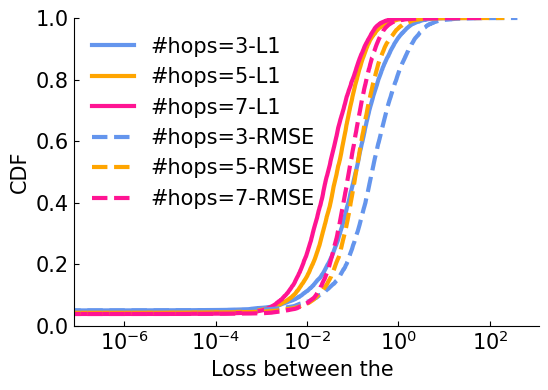

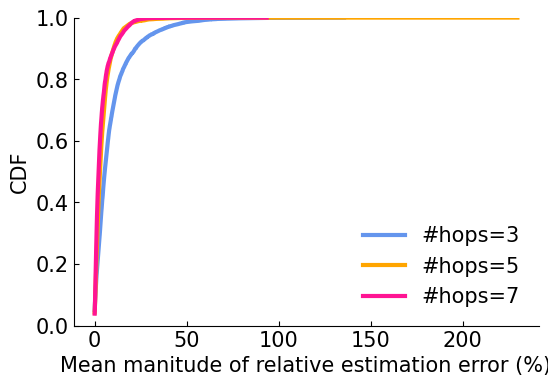

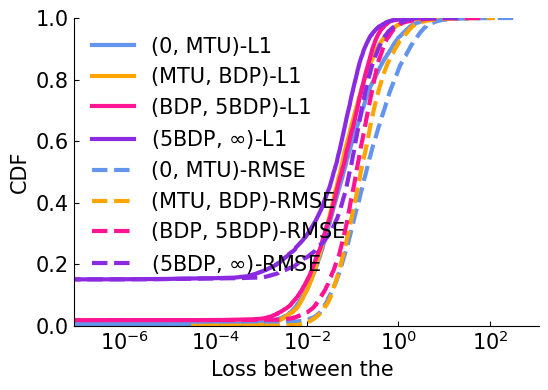

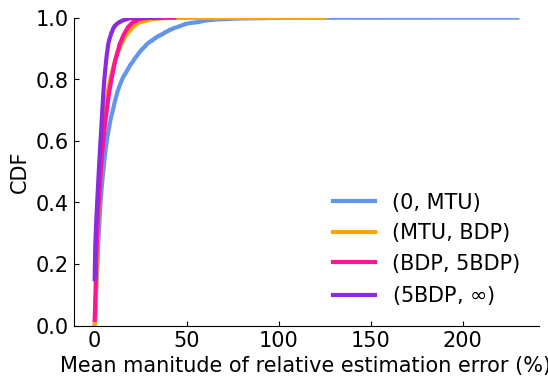

In [42]:
fig_idx=0
res_error_flattened = []
for i in range(res_error.shape[1]):
    res_error_flattened.append(res_error[:,i,:,:,0].flatten())
legend_list=[f"#hops={nhosts}-L1" for nhosts in nhosts_list]
for i in range(res_error.shape[1]):
    res_error_flattened.append(res_error[:,i,:,:,1].flatten())
legend_list+=[f"#hops={nhosts}-RMSE" for nhosts in nhosts_list]
plot_cdf(res_error_flattened,None,legend_list,'Loss between the ',legend_font=15,group_size=len(legend_list)//2,loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)

fig_idx+=1
res_error_flattened = []
for i in range(res_error.shape[1]):
    res_error_flattened.append(res_error[:,i,:,:,2].flatten()*100)
legend_list=[f"#hops={nhosts}" for nhosts in nhosts_list]
plot_cdf(res_error_flattened,None,legend_list,'Mean manitude of relative estimation error (%)',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)


fig_idx+=1
res_error_flattened = []
for i in range(res_error.shape[3]):
    res_error_flattened.append(res_error[:,:,:,i,0].flatten())
legend_list=[f"{tmp}-L1" for tmp in SIZE_BUCKET_LIST_OUTPUT]
for i in range(res_error.shape[3]):
    res_error_flattened.append(res_error[:,:,:,i,1].flatten())
legend_list+=[f"{tmp}-RMSE" for tmp in SIZE_BUCKET_LIST_OUTPUT]
plot_cdf(res_error_flattened,None,legend_list,'Loss between the ',legend_font=15,group_size=len(legend_list)//2,loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)

fig_idx+=1
res_error_flattened = []
for i in range(res_error.shape[3]):
    res_error_flattened.append(res_error[:,:,:,i,2].flatten()*100)
legend_list=[f"{tmp}" for tmp in SIZE_BUCKET_LIST_OUTPUT]
plot_cdf(res_error_flattened,None,legend_list,'Mean manitude of relative estimation error (%)',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)

In [ ]:
res_error_flattened = []
for i in range(res_error.shape[3]):
    res_error_flattened.append(res_error[:,i,:,:,0].flatten())
legend_list=[f"#hops={nhosts}-L1" for nhosts in nhosts_list]
for i in range(res_error.shape[3]):
    res_error_flattened.append(res_error[:,i,:,:,1].flatten())
legend_list+=[f"#hops={nhosts}-RMSE" for nhosts in nhosts_list]
plot_cdf(res_error_flattened,None,legend_list,'Loss between the ',legend_font=15,group_size=len(legend_list)//2,loc=2,rotate_xaxis=False,log_switch=True)

res_error_flattened = []
for i in range(res_error.shape[1]):
    res_error_flattened.append(res_error[:,i,:,:,2].flatten())
legend_list=[f"#hops={nhosts}" for nhosts in nhosts_list]
plot_cdf(res_error_flattened,None,legend_list,'Mean manitude of relative estimation error',legend_font=15,group_size=len(legend_list)//2,loc=2,rotate_xaxis=False,log_switch=True)

1
spec=shard0_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_s0
param_vec=[  0.     36.4    22.879   1.      0.      0.      0.      1.      0.
   0.      0.      0.      0.     50.897 121.182]
sizes=360000, fats=360000, fcts=360000, i_fcts=360000, sldns=360000
169.741s
************************************************************************************************************************************************
shard0_nflows20000_nhosts7_lr10Gbps


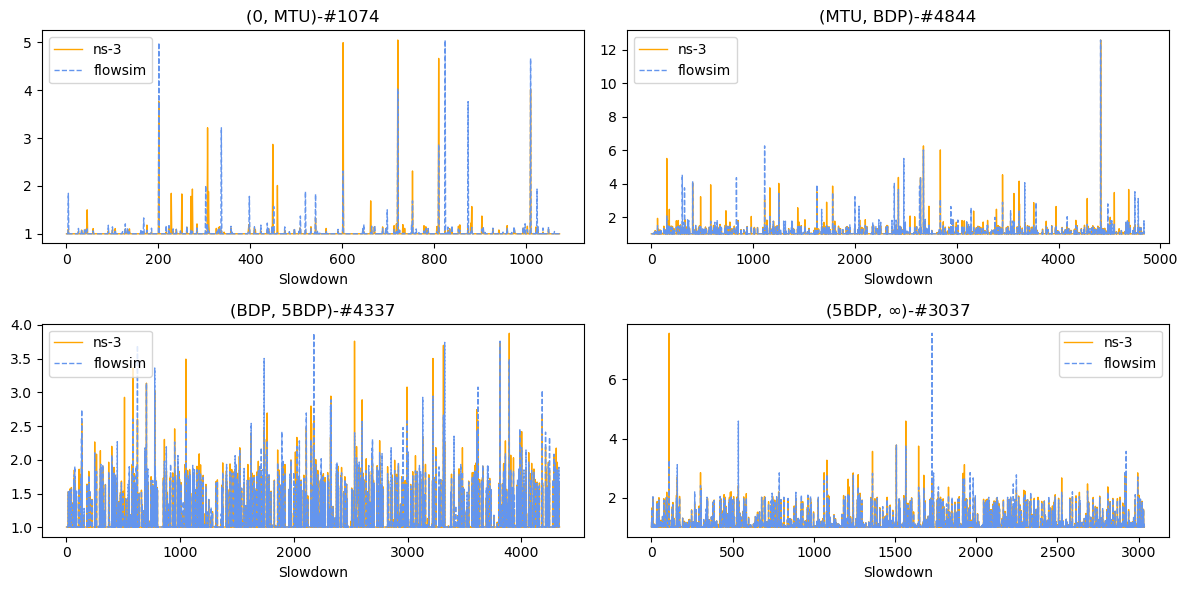

In [19]:

data_list=[]
# for shard in np.arange(10):
for shard in [0]:
    for n_flows in [20000]:
        # for n_hosts in [3,5,7]:
        for n_hosts in [7]:
            # for shard_seed in [0,1,2,3]:
            for shard_seed in [0]:
                topo_type=topo_type_ori.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps{dir_input_str}"
                dir_input_tmp = f"{dir_input}/{spec}"
                stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
                n_flows_total=stats["n_flows"]
                if enable_longest_foreground_traffic:
                    data_list.append((spec,(0,n_hosts-1),topo_type))
print(len(data_list))
# [FINAL]: ns3 vs flowSim
lr_bottleneck=lr


res_error=[]
fig_index=0
plt.figure(fig_index,figsize=(12, 6))
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    print(f"spec={spec},{topo_type}")
    dir_input_tmp = f"{dir_input}/{spec}"
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    
    dctcp_k_str=topo_type[9:]
    
    param_vec = np.load(f"{dir_input_tmp}/param{topo_type}.npy")
    print(f"param_vec={param_vec}")
    
    fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
    sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
    fats_flowsim = np.load(f"{dir_input_tmp}/fat.npy")
    flow_src_dst_flowsim=np.load(f'{dir_input_tmp}/fsd.npy')
    assert is_sorted(fid)
    
    # flowsim
    flow_idx_target_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]==src_dst_pair_target[0], flow_src_dst_flowsim[:,1]==src_dst_pair_target[1])

    flow_idx_nontarget_flowsim=~flow_idx_target_flowsim
    flow_idx_nontarget_internal_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]!=src_dst_pair_target[0], flow_src_dst_flowsim[:,1]!=src_dst_pair_target[1])

    n_links_passed=abs(flow_src_dst_flowsim[:,0]-flow_src_dst_flowsim[:,1])+flow_idx_nontarget_flowsim+flow_idx_nontarget_internal_flowsim
    
    delay_extra=LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,0]]+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,1]]
    base_delay=get_base_delay(sizes_flowsim,n_links_passed,lr_bottleneck,flow_idx_target_flowsim,flow_idx_nontarget_internal_flowsim)+delay_extra
    i_fcts_flowsim = get_base_delay_transmission(sizes_flowsim,lr_bottleneck) + base_delay
    fcts_flowsim = np.load(f'{dir_input}/{spec}/fct_flowsim.npy')+ base_delay
    sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)

    sizes_flowsim_target=sizes_flowsim[flow_idx_target_flowsim]
    sldns_flowsim_target=sldns_flowsim[flow_idx_target_flowsim]
    fcts_flowsim_target=fcts_flowsim[flow_idx_target_flowsim]
    i_fcts_flowsim_target=i_fcts_flowsim[flow_idx_target_flowsim]
    bins_flowsim_target = np.digitize(sizes_flowsim_target, SIZE_BUCKET_LIST)
    
    # ns-3
    sizes=sizes_flowsim[fid]
    fats=fats_flowsim[fid]
    flow_src_dst=flow_src_dst_flowsim[fid]
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    
    fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    # sldns = i_fcts
    
    
    # flow_idx_target=~flow_idx_target
    sizes_target=sizes[flow_idx_target]
    sldns_target=sldns[flow_idx_target]
    fcts_target=fcts[flow_idx_target]
    i_fcts_target=i_fcts[flow_idx_target]
    
    bins_target = np.digitize(sizes_target, SIZE_BUCKET_LIST)
    
    print(f"sizes={len(sizes)}, fats={len(fats)}, fcts={len(fcts)}, i_fcts={len(i_fcts)}, sldns={len(sldns)}")
    deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    print(f"{deq_time_max}s")
    
    print("************************************************************************************************************************************************")
    print(f'{spec}')
    for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
        gt = np.extract(bins_target==i, sldns_target)
        gt_flowsim = np.extract(bins_flowsim_target==i, sldns_flowsim_target)
        
        plt.subplot(2, 2, i + 1)
        plt.title(f"{SIZE_BUCKET_LIST_OUTPUT[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        
        plot_ns3=gt
        plot_flowsim=map_percentiles(gt_flowsim,gt)
        
        res_error.append(np.abs(plot_ns3-plot_flowsim)/plot_ns3)
        plt.plot(plot_flowsim, label="ns-3", linewidth=1,color=color_list[1])
        
        plt.plot(plot_ns3, label="flowsim", linewidth=1,color=color_list[0],linestyle='dashed')

        # plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        plt.xlabel('Slowdown')
        plt.legend()
        # plt.xlim([0, 16])
        # plt.ylim([80, 100])
    plt.tight_layout()
fig_index+=1


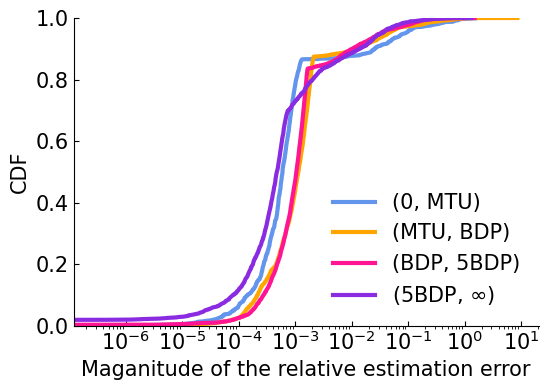

In [21]:

plot_cdf(res_error,None,SIZE_BUCKET_LIST_OUTPUT,'Maganitude of the relative estimation error',legend_font=15,group_size=len(SIZE_BUCKET_LIST_OUTPUT),loc=4,rotate_xaxis=False,log_switch=True)

spec=shard0_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_s0
param_vec=[  0.     36.4    22.879   1.      0.      0.      0.      1.      0.
   0.      0.      0.      0.     50.897 121.182]
sizes=360000, fats=360000, fcts=360000, i_fcts=360000, sldns=360000
169.741s
************************************************************************************************************************************************
shard0_nflows20000_nhosts7_lr10Gbps
p99 percentile: 1.1717407146342165
p99 percentile: 1.5195368993879506
p99 percentile: 1.8508335405588012
p99 percentile: 1.9454807485170909
spec=shard0_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_s1
param_vec=[ 0.    32.5   23.008  1.     0.     1.     0.     0.     0.    29.
 57.     0.     0.     0.     0.   ]
sizes=360000, fats=360000, fcts=360000, i_fcts=360000, sldns=360000
169.741s
************************************************************************************************************************************************
shard0_nflows20000_nhosts

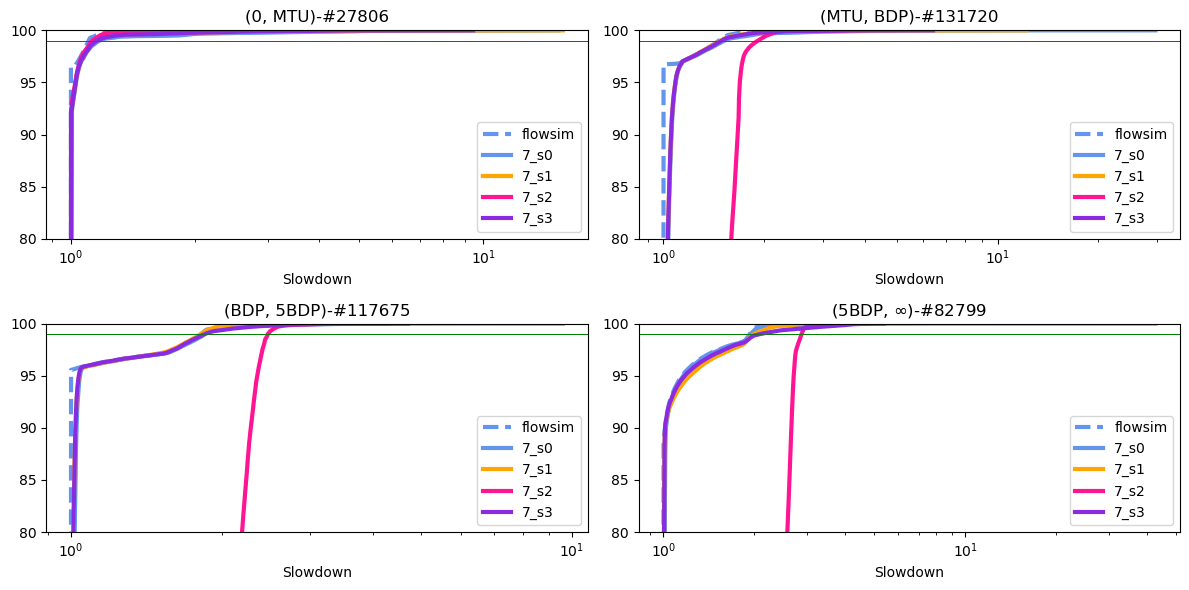

In [9]:
data_list=[]
# for shard in np.arange(10):
for shard in [0]:
    for n_flows in [20000]:
        # for n_hosts in [3,5,7]:
        for n_hosts in [7]:
            # for shard_seed in [0,1,2,3]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps{dir_input_str}"
                dir_input_tmp = f"{dir_input}/{spec}"
                stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
                n_flows_total=stats["n_flows"]
                if enable_longest_foreground_traffic:
                    data_list.append((spec,(0,n_hosts-1),topo_type_cur))
print(len(data_list))
# [FINAL]: ns3 vs flowSim
lr_bottleneck=lr
fig_index=0
plt.figure(fig_index,figsize=(12, 6))
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    print(f"spec={spec},{topo_type}")
    dir_input_tmp = f"{dir_input}/{spec}"
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    
    dctcp_k_str=topo_type[9:]
    
    param_vec = np.load(f"{dir_input_tmp}/param{topo_type}.npy")
    print(f"param_vec={param_vec}")
    
    fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
    sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
    fats_flowsim = np.load(f"{dir_input_tmp}/fat.npy")
    flow_src_dst_flowsim=np.load(f'{dir_input_tmp}/fsd.npy')
    
    if (spec_idx==0):
        # flowsim
        flow_idx_target_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]==src_dst_pair_target[0], flow_src_dst_flowsim[:,1]==src_dst_pair_target[1])

        flow_idx_nontarget_flowsim=~flow_idx_target_flowsim
        flow_idx_nontarget_internal_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]!=src_dst_pair_target[0], flow_src_dst_flowsim[:,1]!=src_dst_pair_target[1])

        n_links_passed=abs(flow_src_dst_flowsim[:,0]-flow_src_dst_flowsim[:,1])+flow_idx_nontarget_flowsim+flow_idx_nontarget_internal_flowsim
        
        delay_extra=LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,0]]+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,1]]
        base_delay=get_base_delay(sizes_flowsim,n_links_passed,lr_bottleneck,flow_idx_target_flowsim,flow_idx_nontarget_internal_flowsim)+delay_extra
        i_fcts_flowsim = get_base_delay_transmission(sizes_flowsim,lr_bottleneck) + base_delay
        fcts_flowsim = np.load(f'{dir_input}/{spec}/fct_flowsim.npy')+ base_delay
        sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)

        sizes_flowsim_target=sizes_flowsim[flow_idx_target_flowsim]
        sldns_flowsim_target=sldns_flowsim[flow_idx_target_flowsim]
        fcts_flowsim_target=fcts_flowsim[flow_idx_target_flowsim]
        i_fcts_flowsim_target=i_fcts_flowsim[flow_idx_target_flowsim]
        bins_flowsim = np.digitize(sizes_flowsim, SIZE_BUCKET_LIST)
    
    # ns-3
    sizes=sizes_flowsim[fid]
    fats=fats_flowsim[fid]
    flow_src_dst=flow_src_dst_flowsim[fid]
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    
    fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    # sldns = i_fcts
    
    
    # flow_idx_target=~flow_idx_target
    sizes_target=sizes[flow_idx_target]
    sldns_target=sldns[flow_idx_target]
    fcts_target=fcts[flow_idx_target]
    i_fcts_target=i_fcts[flow_idx_target]
    
    bins = np.digitize(sizes, SIZE_BUCKET_LIST)
    
    print(f"sizes={len(sizes)}, fats={len(fats)}, fcts={len(fcts)}, i_fcts={len(i_fcts)}, sldns={len(sldns)}")
    deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    print(f"{deq_time_max}s")
    
    print("************************************************************************************************************************************************")
    print(f'{spec}')
    for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
        gt = np.extract(bins==i, sldns)
        gt_flowsim = np.extract(bins_flowsim==i, sldns_flowsim)
            
        print(f"p99 percentile: {np.percentile(gt,99)}")
        
        plt.subplot(2, 2, i + 1)
        plt.title(f"{SIZE_BUCKET_LIST_OUTPUT[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        
        if (spec_idx==0):
            plt.plot(np.sort(gt_flowsim), (np.arange(len(gt_flowsim))/len(gt_flowsim)*100), label="flowsim", linewidth=3,color=color_list[spec_idx],linestyle='dashed')
            
        plt.plot(np.sort(gt), (np.arange(len(gt))/len(gt)*100), label=dctcp_k_str, linewidth=3,color=color_list[spec_idx])

        plt.axhline(99, color='green', linewidth=0.5)
        plt.xscale('log')
        plt.xlabel('Slowdown')
        plt.legend()
        plt.ylim([80, 100])
    plt.tight_layout()
fig_index+=1

# plot_cdf(res,None,legend_list,'P99 slowdown',legend_font=15,group_size=len(res),loc=4,rotate_xaxis=False)